In [1]:
import torch
from model import Model
from dataLoader import get_data_loader
from lossFn import SideTeacherLoss
import torch.optim as optim
import os
import numpy as np

device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

class Option:
    def __str__(self):
        return str(vars(self))
    
args = Option()
args.dataset = "cifar100"
args.alpha = 0.005
args.num_teachers = 10 
args.batch_size = 64
args.epoch_num = 101
args.learning_rate = 0.005


cuda


In [2]:
# 1. get dataloader
train_loader, test_loader = get_data_loader(args.batch_size, args.dataset)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# 2. define out_c, in_c, in_h, in_w
# - out_c = # output class
# - in_c = # input channel
# - in_h = input height
# - in_w = input width
out_c = len(train_loader.dataset.classes)
if (len(train_loader.dataset.data.shape) == 3):
    _, in_h, in_w = train_loader.dataset.data.shape
    in_c = 1
else:
    _, in_h, in_w, in_c = train_loader.dataset.data.shape

In [4]:
# 3. define teacher, student, baseline models
teachers = [Model(in_c, in_w, in_h, out_c).to(device) for _ in range(args.num_teachers)]
students = {
    "l2-neg": Model(in_c, in_w, in_h, out_c).to(device),
    "l1-neg": Model(in_c, in_w, in_h, out_c).to(device),
    "fro-neg": Model(in_c, in_w, in_h, out_c).to(device),
    # "nuc-neg": Model(in_c, in_w, in_h, out_c).to(device),
    "l2-recp": Model(in_c, in_w, in_h, out_c).to(device),
    "l1-recp": Model(in_c, in_w, in_h, out_c).to(device),
    "fro-recp": Model(in_c, in_w, in_h, out_c).to(device),
    # "nuc-recp": Model(in_c, in_w, in_h, out_c).to(device),
}
baselines = {
    "default": Model(in_c, in_w, in_h, out_c).to(device),
    "weight-decay": Model(in_c, in_w, in_h, out_c).to(device),
}
# - default와 같은 값으로 초기화
for student in students.values():
    for name, p in student.layers.named_parameters():
        p.data = torch.nn.Parameter(baselines["default"].layers.get_parameter(name).clone())
for name, p in baselines["weight-decay"].layers.named_parameters():
    p.data = torch.nn.Parameter(baselines["default"].layers.get_parameter(name).clone())

In [5]:
# 4. define optimizer and loss function
teacher_optimizers = [optim.SGD(teachers[i].parameters(), lr=args.learning_rate)for i in range(args.num_teachers)]
teacher_loss_fn = torch.nn.CrossEntropyLoss()

In [6]:
# 5. train teacher
# if already exist then use that teacher
if os.path.exists(f"param/{args.dataset}/alpha=={args.alpha}"):
    for idx, teacher in enumerate(teachers):
        teacher.load(f"param/{args.dataset}/alpha=={args.alpha}/teacher{idx}")
    print("teacher is successfully loaded")
else:
    tot_batch_num = len(train_loader)
    teacher_batch_num = tot_batch_num // args.num_teachers
    teacher_result = {
        "train_loss": np.zeros((args.epoch_num // 5 + 1, args.num_teachers)),
        "train_acc": np.zeros((args.epoch_num // 5 + 1, args.num_teachers)),
        "test_loss": np.zeros((args.epoch_num // 5 + 1, args.num_teachers)),
        "test_acc": np.zeros((args.epoch_num // 5 + 1, args.num_teachers)),
    }
    for epoch in range(args.epoch_num):
        epoch_losses = np.zeros(args.num_teachers)
        epoch_tf = np.zeros(args.num_teachers)
        for cur_batch_num, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            teacher_idx = cur_batch_num // teacher_batch_num
            if teacher_idx == args.num_teachers:
                break
            pred = teachers[teacher_idx](X)
            loss = teacher_loss_fn(pred, y)
            teacher_optimizers[teacher_idx].zero_grad()
            loss.backward()
            teacher_optimizers[teacher_idx].step()
            epoch_losses[teacher_idx] += loss.item()
            epoch_tf[teacher_idx] += (pred.argmax(1) == y).type(torch.float).sum().item()
        print(f'Epoch {epoch}=====================================')
        for teacher_idx in range(args.num_teachers):
            print(f'teacher {teacher_idx} loss: {epoch_losses[teacher_idx] / (teacher_batch_num * args.batch_size):.6f} acc: {epoch_tf[teacher_idx] / (teacher_batch_num * args.batch_size):.6f}')
        if epoch % 5 == 0:
            teacher_result["train_loss"][epoch // 5] = epoch_losses / (teacher_batch_num * args.batch_size)
            teacher_result["train_acc"][epoch // 5] = epoch_tf / (teacher_batch_num * args.batch_size)
            # test 수행
            losses = np.zeros(args.num_teachers)
            tf = np.zeros(args.num_teachers)
            test_batch_num = len(test_loader)
            with torch.no_grad():
                for cur_batch_num, (X, y) in enumerate(test_loader):
                    X, y = X.to(device), y.to(device)
                    for teacher_idx in range(args.num_teachers):
                        pred = teachers[teacher_idx](X)
                        loss = teacher_loss_fn(pred, y)
                        losses[teacher_idx] += loss.item()
                        tf[teacher_idx] += (pred.argmax(1) == y).type(torch.float).sum().item()
            teacher_result["test_loss"][epoch // 5] = losses / (test_batch_num * args.batch_size)
            teacher_result["test_acc"][epoch // 5] = tf / (test_batch_num * args.batch_size)

Epoch 0=====================================
teacher 0 loss: 0.071954 acc: 0.013421
teacher 1 loss: 0.071949 acc: 0.010617
teacher 2 loss: 0.071954 acc: 0.011418
teacher 3 loss: 0.071944 acc: 0.010617
teacher 4 loss: 0.071964 acc: 0.011018
teacher 5 loss: 0.071941 acc: 0.011619
teacher 6 loss: 0.071949 acc: 0.007412
teacher 7 loss: 0.071950 acc: 0.007011
teacher 8 loss: 0.071954 acc: 0.009014
teacher 9 loss: 0.071941 acc: 0.008213
Epoch 1=====================================
teacher 0 loss: 0.071906 acc: 0.013822
teacher 1 loss: 0.071880 acc: 0.012420
teacher 2 loss: 0.071920 acc: 0.013221
teacher 3 loss: 0.071879 acc: 0.011819
teacher 4 loss: 0.071922 acc: 0.014623
teacher 5 loss: 0.071908 acc: 0.012821
teacher 6 loss: 0.071911 acc: 0.014223
teacher 7 loss: 0.071898 acc: 0.011018
teacher 8 loss: 0.071926 acc: 0.010617
teacher 9 loss: 0.071864 acc: 0.009816
Epoch 2=====================================
teacher 0 loss: 0.071856 acc: 0.015625
teacher 1 loss: 0.071801 acc: 0.014223
teacher

In [7]:
# 6. train student, base_model, weight_decay_model
student_optimizers = {s_name: optim.SGD(student.parameters(), lr=args.learning_rate) for s_name, student in students.items()}
baseline_optimizers = {
    "default": optim.SGD(baselines["default"].parameters(), lr=args.learning_rate),
    "weight-decay": optim.SGD(baselines["weight-decay"].parameters(), lr=args.learning_rate, weight_decay=args.alpha)
}

student_loss_fns = {s_name: SideTeacherLoss(student, torch.nn.CrossEntropyLoss(), device, alpha=args.alpha, teachers=teachers,dist=s_name) for s_name, student in students.items()}
baseline_loss_fn = torch.nn.CrossEntropyLoss()

student_result = {
    "train_loss": {s_name: np.zeros(args.epoch_num // 5 + 1) for s_name in students.keys()},
    "train_acc": {s_name: np.zeros(args.epoch_num // 5 + 1) for s_name in students.keys()},
    "test_loss": {s_name: np.zeros(args.epoch_num // 5 + 1) for s_name in students.keys()},
    "test_acc": {s_name: np.zeros(args.epoch_num // 5 + 1) for s_name in students.keys()},
}
baseline_result = {
    "train_loss": {b_name: np.zeros(args.epoch_num // 5 + 1) for b_name in baselines.keys()},
    "train_acc": {b_name: np.zeros(args.epoch_num // 5 + 1) for b_name in baselines.keys()},
    "test_loss": {b_name: np.zeros(args.epoch_num // 5 + 1) for b_name in baselines.keys()},
    "test_acc": {b_name: np.zeros(args.epoch_num // 5 + 1) for b_name in baselines.keys()},
}

batch_num = len(train_loader)
for epoch in range(args.epoch_num):
    student_losses = {s_name: 0 for s_name in students.keys()}
    student_tf = {s_name: 0 for s_name in students.keys()}
    baseline_losses = {b_name: 0 for b_name in baselines.keys()}
    baseline_tf = {b_name: 0 for b_name in baselines.keys()}
    for cur_batch_num, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        for s_name, student in students.items():
            pred = student(X)
            loss = student_loss_fns[s_name](pred, y)
            student_optimizers[s_name].zero_grad()
            loss.backward()
            student_optimizers[s_name].step()
            student_losses[s_name] += loss.item()
            student_tf[s_name] += (pred.argmax(1) == y).type(torch.float).sum().item()
        for b_name, baseline in baselines.items():
            pred = baseline(X)
            loss = baseline_loss_fn(pred, y)
            baseline_optimizers[b_name].zero_grad()
            loss.backward()
            baseline_optimizers[b_name].step()
            baseline_losses[b_name] += loss.item()
            baseline_tf[b_name] += (pred.argmax(1) == y).type(torch.float).sum().item()
    print(f'Epoch {epoch}=====================================')
    for s_name in students.keys():
        print(f'student {s_name} loss: {student_losses[s_name] / (batch_num * args.batch_size):.6f} acc: {student_tf[s_name] / (batch_num * args.batch_size):.6f}')
    for b_name in baselines.keys():
        print(f'baseline {b_name} loss: {baseline_losses[b_name] / (batch_num * args.batch_size):.6f} acc: {baseline_tf[b_name] / (batch_num * args.batch_size):.6f}')
    if epoch % 5 == 0:
        for s_name in students.keys():
            student_result["train_loss"][s_name][epoch // 5] = student_losses[s_name] / (batch_num * args.batch_size)
            student_result["train_acc"][s_name][epoch // 5] = student_tf[s_name] / (batch_num * args.batch_size)
        for b_name in baselines.keys():
            baseline_result["train_loss"][b_name][epoch // 5] = baseline_losses[b_name] / (batch_num * args.batch_size)
            baseline_result["train_acc"][b_name][epoch // 5] = baseline_tf[b_name] / (batch_num * args.batch_size)
        # test 수행
        s_losses = {s_name: 0 for s_name in students.keys()}
        s_tf = {s_name: 0 for s_name in students.keys()}
        b_losses = {b_name: 0 for b_name in baselines.keys()}
        b_tf = {b_name: 0 for b_name in baselines.keys()}
        test_batch_num = len(test_loader)
        with torch.no_grad():
            for cur_batch_num, (X, y) in enumerate(test_loader):
                X, y = X.to(device), y.to(device)
                for s_name, student in students.items():
                    pred = student(X)
                    loss = student_loss_fns[s_name](pred, y)
                    s_losses[s_name] += loss.item()
                    s_tf[s_name] += (pred.argmax(1) == y).type(torch.float).sum().item()
                for b_name, baseline in baselines.items():
                    pred = baseline(X)
                    loss = baseline_loss_fn(pred, y)
                    b_losses[b_name] += loss.item()
                    b_tf[b_name] += (pred.argmax(1) == y).type(torch.float).sum().item()
        for s_name in students.keys():
            student_result["test_loss"][s_name][epoch // 5] = s_losses[s_name] / (test_batch_num * args.batch_size)
            student_result["test_acc"][s_name][epoch // 5] = s_tf[s_name] / (test_batch_num * args.batch_size)
            print(f'[TEST]student {s_name} loss: {s_losses[s_name] / (test_batch_num * args.batch_size):.6f} acc: {s_tf[s_name] / (test_batch_num * args.batch_size):.6f}')
        for b_name in baselines.keys():
            baseline_result["test_loss"][b_name][epoch // 5] = b_losses[b_name] / (test_batch_num * args.batch_size)
            baseline_result["test_acc"][b_name][epoch // 5] = b_tf[b_name] / (test_batch_num * args.batch_size)
            print(f'[TEST]baseline {b_name} loss: {b_losses[b_name] / (test_batch_num * args.batch_size):.6f} acc: {b_tf[b_name] / (test_batch_num * args.batch_size):.6f}')

Epoch 0=====================================
student l2-neg loss: -0.775770 acc: 0.043478
student l1-neg loss: nan acc: 0.022019
student fro-neg loss: 0.032658 acc: 0.022379
student l2-recp loss: 0.075442 acc: 0.021240
student l1-recp loss: 0.072526 acc: 0.020061
student fro-recp loss: 0.075976 acc: 0.020161
baseline default loss: 0.071312 acc: 0.020660
baseline weight-decay loss: 0.071350 acc: 0.019961
[TEST]student l2-neg loss: -1.006408 acc: 0.083400
[TEST]student l1-neg loss: nan acc: 0.009952
[TEST]student fro-neg loss: 0.030345 acc: 0.036823
[TEST]student l2-recp loss: 0.071966 acc: 0.035629
[TEST]student l1-recp loss: 0.070825 acc: 0.033738
[TEST]student fro-recp loss: 0.073519 acc: 0.033539
[TEST]baseline default loss: 0.069659 acc: 0.033937
[TEST]baseline weight-decay loss: 0.069786 acc: 0.032643
Epoch 1=====================================
student l2-neg loss: -1.386582 acc: 0.132693
student l1-neg loss: nan acc: 0.009990
student fro-neg loss: 0.026793 acc: 0.068594
student l

In [8]:
# 7. save model param
dir = f"param/{args.dataset}/alpha=={args.alpha}"
try:
    if not os.path.exists(dir):
        os.makedirs(dir)
except OSError:
    print ('Error: Creating directory. ' +  dir)
for i in range(args.num_teachers):
    teachers[i].eval()
    teachers[i].save(f"{dir}/teacher{i}")
for s_name, student in students.items():
    student.eval()
    student.save(f"{dir}/{s_name}")
for b_name, baseline in baselines.items():
    baseline.eval()
    baseline.save(f"{dir}/{b_name}")

In [9]:
# 8. save loss, acc
dir = f"result/{args.dataset}/alpha=={args.alpha}"
try:
    if not os.path.exists(dir):
        os.makedirs(dir)
except OSError:
    print ('Error: Creating directory. ' +  dir)
for metric, m in student_result.items():
    for s_name, s in m.items():
        np.save(f"{dir}/{metric}_{s_name}.npy", s)
for metric, m in baseline_result.items():
    for b_name, b in m.items():
        np.save(f"{dir}/{metric}_{b_name}.npy", b)
for metric, m in teacher_result.items():
    for t in range(args.num_teachers):
        np.save(f"{dir}/{metric}_teacher{t}.npy", m[:, t])
print("Done!")

Done!


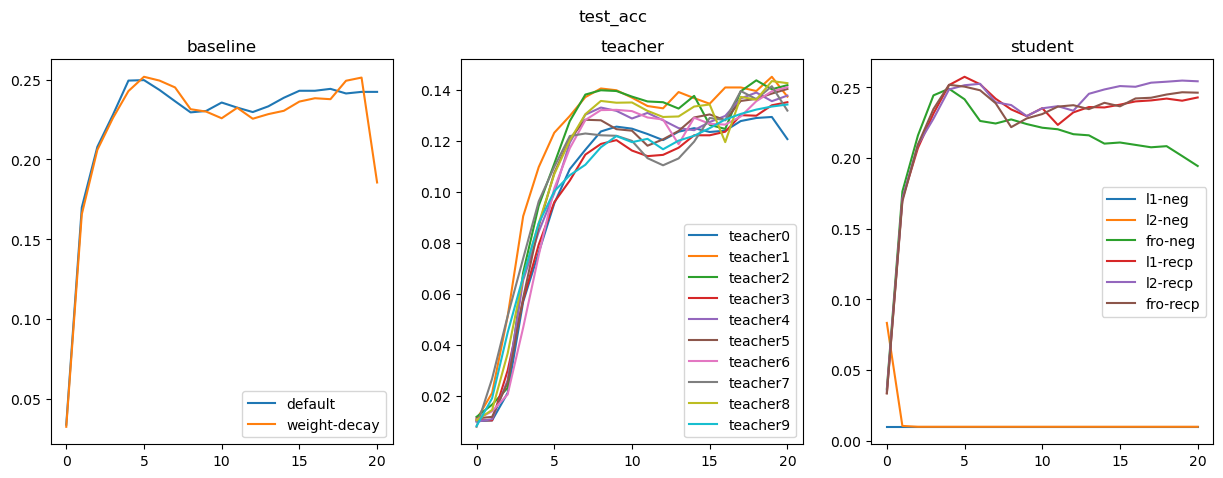

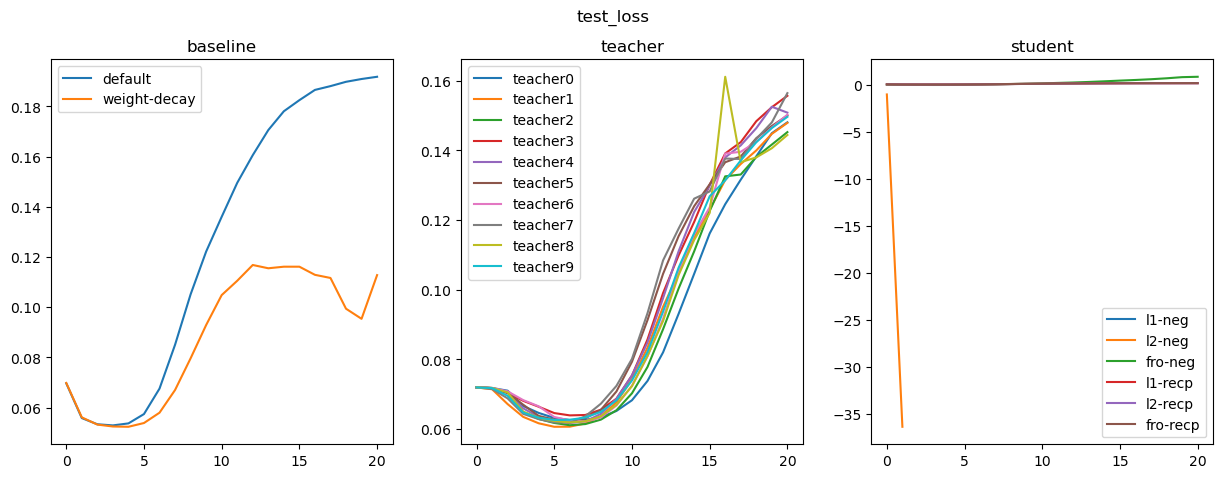

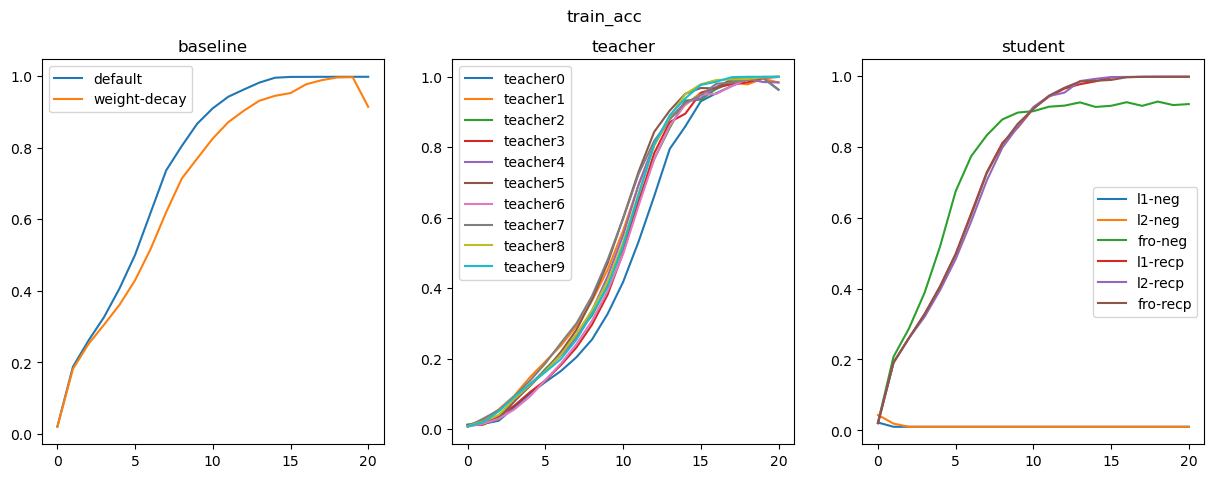

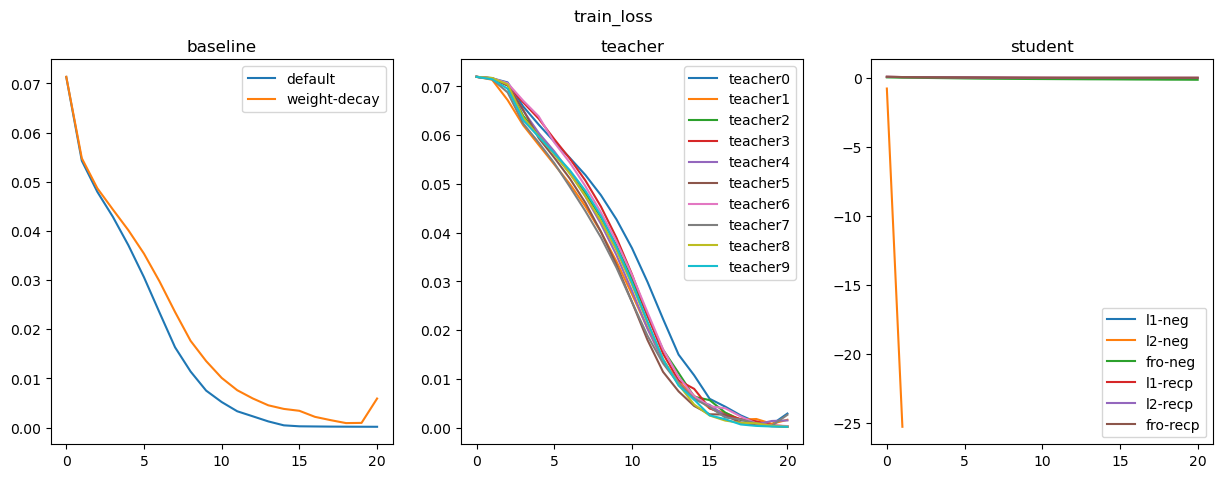

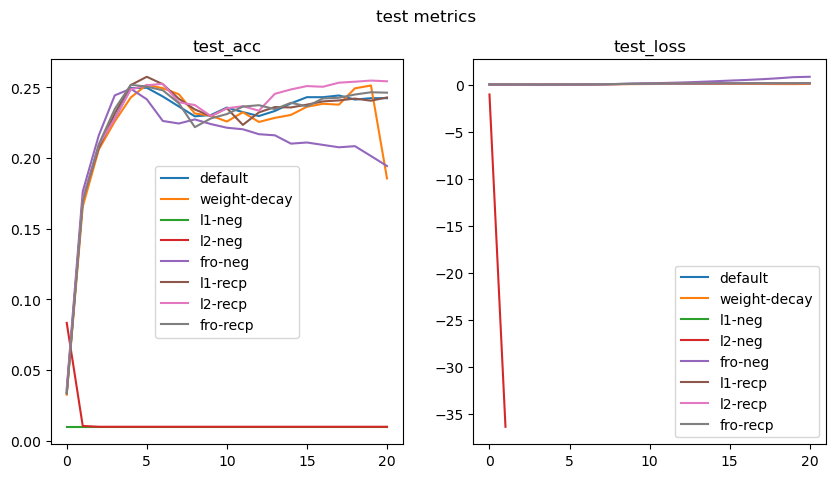

In [10]:
from drawer import draw_base_and_student, draw_each
import matplotlib.pyplot as plt

draw_each(args.dataset, args.alpha)
draw_base_and_student(args.dataset, args.alpha)
plt.show()